In [2]:
import numpy as np
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from keras.preprocessing.sequence import pad_sequences
from pickle import dump, load
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


## Task 1

In [3]:
def get_train_data(textfile, window_size, stride):
    # open the file as read, read text, and close file
    file = open(textfile, 'r')
    text = file.read()
    file.close()
    
    # strip of the new line characters so that we 
    # have one long sequence of characters separated only 
    # by white space
    tokens = text.split()
    data = ' '.join(tokens)
    
    # get sequences of characters of length window_size+1
    sequences = []
    for i in range(window_size, len(data), stride):
        sequence = data[i - window_size: i + 1]
        sequences.append(sequence)
    print('Total Sequences: %d' % len(sequences))
    
    # save sequences 
    data = '\n'.join(sequences)
    file = open('train_data.txt', 'w')
    file.write(data)
    file.close()

In [3]:
get_train_data('beatles.txt', window_size=10, stride=1)

Total Sequences: 166732


## Task 2

In [27]:
def preprocess_data(train_textfile):
    # open the file as read, read text, and close file
    file = open(train_textfile, 'r')
    text = file.read()
    file.close()
    
    # get list of sequences by splitting the text by new line
    lines = text.split('\n')
    
    # get unique characters
    chars = sorted(list(set(text)))
    # get mapping of character to integer values and store in a dictionary
    char_to_i_mapping = dict((c, i) for i, c in enumerate(chars))
    # save the mapping
    dump(char_to_i_mapping, open('mapping.pkl', 'wb'))
    # get vocabulary size
    vocab_size = len(char_to_i_mapping)
    print('Vocabulary size: %d' % vocab_size)
    
    # integer encode each sequence of characters using the dictionary mapping
    sequences = []
    for line in lines:
        # integer encode line
        encoded_seq = [char_to_i_mapping[char] for char in line]
        # store
        sequences.append(encoded_seq)
    
    # now separate the integer encoded sequences into input and output
    sequences = np.array(sequences)
    X = sequences[:,:-1]
    y = sequences[:,-1]
    
    # now one-hot encode each character, meaning each character becomes a vector of length vocab_size with a 1 marked 
    # for the character and 0s elsewhere
    sequences = [to_categorical(x, num_classes=vocab_size) for x in X]
    X = np.array(sequences)
    y = to_categorical(y, num_classes=vocab_size)
    print('X shape: %s and y shape: %s' %(X.shape, y.shape))
    
    return(X, y)

In [28]:
X, y = preprocess_data('train_data.txt')

Vocabulary size: 48
X shape: (33347, 10, 48) and y shape: (33347, 48)


## Task 3

In [29]:
def predict_characters(model, mapping, window_size, init_chars, n_chars):
    text = init_chars
    # predict a fixed number of characters
    for i in range(n_chars):
        # integer encode the characters
        encoded = [mapping[chara] for chara in text]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=window_size, truncating='pre')
        # one hot encode
        encoded = to_categorical(encoded, num_classes=len(mapping))
        # predict the next character
        pred_char = model.predict_classes(encoded, verbose=0)
        # reverse mapping of predicted character (integer to character)
        out_char = ''
        for char, index in mapping.items():
            if index == pred_char:
                out_char = char
                break
        # append to input
        text += out_char
    return text

In [30]:
# load the mapping
mapping = load(open('mapping.pkl', 'rb'))
# load the model
model = load_model('models/rnn_100.h5')
print(model.summary())

# test start
print(predict_characters(model, mapping, 10, 'a day in t', 20))
# test middle
#print(predict_characters(model, mapping, 10, 'we just ca', 20))
# test something random
#print(predict_characters(model, mapping, 10, 'now (yeah.', 20))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 100)               14900     
_________________________________________________________________
dense_1 (Dense)              (None, 48)                4848      
Total params: 19,748
Trainable params: 19,748
Non-trainable params: 0
_________________________________________________________________
None
a day in the wello. whot co to


## Task 4

In [41]:
class predict_during_training(keras.callbacks.Callback):    
    def __init__(self, model, sequences):
        self.model = model
        self.sequences = sequences
        
    def on_epoch_end(self, epoch, logs=None):
        mapping = load(open('mapping.pkl', 'rb'))
        window_size = len(self.sequences[0])
        if epoch%5 == 0:
            for i in self.sequences:
                text = predict_characters(self.model, mapping, window_size=window_size, 
                                      init_chars=i, n_chars=10)
                print(text) # return prediction
            print()

def train_model(model, X, y, n_epochs, model_name):
    # open the file as read, read text, and close file
    file = open('train_data.txt', 'r')
    text = file.read()
    file.close()
    # get list of sequences by splitting the text by new line
    lines = text.split('\n')
        
    # get list of 3 random sequences from training data which will be used to 
    # generate/predict characters during training
    random_indexes = list(np.random.randint(low=0, high=len(lines) - X.shape[1] - 1, size=3))
    random_sequences = [lines[index][:-1] for index in random_indexes]
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # fit model
    history = model.fit(X, y, epochs=n_epochs, verbose=1, 
                        callbacks=[predict_during_training(model, random_sequences)])
    # save model for later use
    model.save('models/%s.h5' %(model_name))
    # save model history
    with open('train_history/%s.pkl' %(model_name), 'wb') as file:
        dump(history.history, file)
        
    # Plot training loss values vs epochs
    epoch_loss_plot(history.history, n_epochs, model_name)
    
    return history

In [37]:
def epoch_loss_plot(history_dict, n_epochs, model_name):
    # Plot training loss values vs epochs
    #plt.figure(figsize=(10,8))
    plt.plot(history_dict['loss'])
    plt.title('Loss vs. Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper right')
    plt.savefig('plots/epoch_loss_%s.png' %(model_name))
    plt.show()

In [38]:
# load the mapping and get vocab size
mapping = load(open('mapping.pkl', 'rb'))
vocab_size = len(mapping)
print('Vocabulary size: %d' % vocab_size)

Vocabulary size: 48


In [39]:
# LSTM: 
test = Sequential()
test.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
test.add(Dense(vocab_size, activation='softmax'))
print(test.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 75)                37200     
_________________________________________________________________
dense_2 (Dense)              (None, 48)                3648      
Total params: 40,848
Trainable params: 40,848
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/20
200/200 [==============================] - 1s 6ms/step - loss: 3.8585
ake it up,or  notoru u nouu no
n see thema n nippc..c.macaaft
ike you. luu otor u notoru u n

Epoch 2/20
200/200 [==============================] - 0s 701us/step - loss: 3.8075
Epoch 3/20
200/200 [==============================] - 0s 708us/step - loss: 3.7297
Epoch 4/20
200/200 [==============================] - 0s 712us/step - loss: 3.5420
Epoch 5/20
200/200 [==============================] - 0s 717us/step - loss: 3.1234
Epoch 6/20
200/200 [==============================] - 0s 716us/step - loss: 2.9347
ake it up,                    
n see them                    
ike you. l                    

Epoch 7/20
200/200 [==============================] - 0s 726us/step - loss: 2.8493
Epoch 8/20
200/200 [==============================] - 0s 709us/step - loss: 2.8131
Epoch 9/20
200/200 [==============================] - 0s 718us/step - loss: 2.7884
Epoch 10/20
200/200 [==============================] - 0s 719us/ste

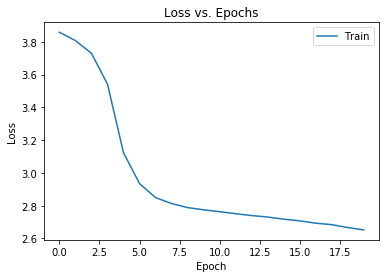

In [40]:
history = train_model(test, X[:200], y[:200], n_epochs=20, model_name='test')

## Task 5

In [ ]:
# load the mapping
mapping = load(open('mapping.pkl', 'rb'))
# load model
model = load_model('models/rnn_100.h5')
print(model.summary())

# test start
print(predict_characters(model, mapping, 10, 'a day in t', 20))
# test middle
print(predict_characters(model, mapping, 10, 'we just ca', 20))
# test something random
print(predict_characters(model, mapping, 10, 'now (yeah.', 20))

In [99]:
# SimpleRNN: 75
model1 = Sequential() 
model1.add(SimpleRNN(50, input_dim=vocab_size)) 
model1.add(Dense(vocab_size))
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 50)                4950      
_________________________________________________________________
dense_5 (Dense)              (None, 48)                2448      
Total params: 7,398
Trainable params: 7,398
Non-trainable params: 0
_________________________________________________________________


/Users/annanau/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/annanau/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(50, input_shape=(None, 48))`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
166732/166732 [==============================] - 30s 179us/step - loss: 8.3699
'cos i kno     

Epoch 2/10
166732/166732 [==============================] - 31s 185us/step - loss: 8.1892

Epoch 3/10
166732/166732 [==============================] - 31s 187us/step - loss: 8.3546
y yes we'r     

Epoch 4/10
166732/166732 [==============================] - 31s 183us/step - loss: 8.5015

Epoch 5/10
166732/166732 [==============================] - 31s 188us/step - loss: 8.1620
, she’s go     

Epoch 6/10
166732/166732 [==============================] - 33s 200us/step - loss: 8.3374

Epoch 7/10
166732/166732 [==============================] - 33s 198us/step - loss: 8.1473
 she keeps     

Epoch 8/10
166732/166732 [==============================] - 34s 202us/step - loss: 8.1349

Epoch 9/10
166732/166732 [==============================] - 33s 200us/step - loss: 8.0701
joob. expe     

Epoch 10/10
166732/166732 [==============================] - 33s 198us/step - loss: 8.1263



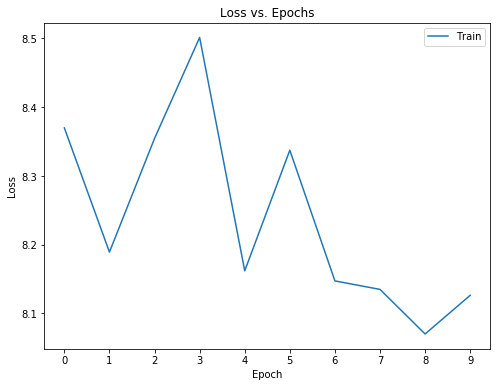

In [100]:
train_model(model1, X, y, n_epochs=10)

In [103]:
model1.save('model1.h5')

In [ ]:
# SimpleRNN
model2 = Sequential() 
model2.add(SimpleRNN(100, input_dim=vocab_size)) 
model2.add(Dense(vocab_size))
model2.summary()

In [ ]:
model.save('model2.h5')

In [ ]:
# SimpleRNN
model3 = Sequential() 
model3.add(SimpleRNN(100, input_dim=vocab_size)) 
model3.add(Dense(vocab_size))
model3.summary()

In [ ]:
model.save('model3.h5')

In [ ]:
# SimpleRNN
model4 = Sequential() 
model4.add(SimpleRNN(100, input_dim=vocab_size)) 
model4.add(Dense(vocab_size))
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 75)                37200     
_________________________________________________________________
dense_2 (Dense)              (None, 48)                3648      
Total params: 40,848
Trainable params: 40,848
Non-trainable params: 0
_________________________________________________________________
None


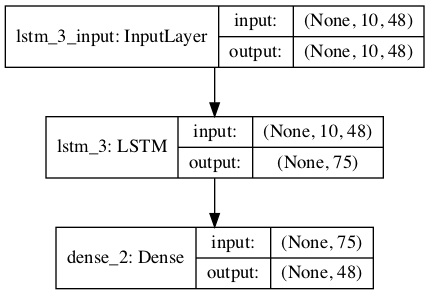

In [13]:
# LSTM: 
model5 = Sequential()
model5.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
model5.add(Dense(vocab_size, activation='softmax'))
print(model5.summary())
plot_model(model5, 'models/model5.png', show_shapes=True)

Epoch 1/50
166732/166732 [==============================] - 32s 194us/step - loss: 2.8418
's in blac io the to

Epoch 2/50
166732/166732 [==============================] - 33s 196us/step - loss: 2.3375

Epoch 3/50
166732/166732 [==============================] - 35s 208us/step - loss: 2.1706

Epoch 4/50
166732/166732 [==============================] - 34s 205us/step - loss: 2.0802

Epoch 5/50
166732/166732 [==============================] - 34s 205us/step - loss: 2.0130

Epoch 6/50
166732/166732 [==============================] - 34s 204us/step - loss: 1.9572

Epoch 7/50
166732/166732 [==============================] - 35s 210us/step - loss: 1.9104

Epoch 8/50
166732/166732 [==============================] - 36s 219us/step - loss: 1.8671

Epoch 9/50
166732/166732 [==============================] - 34s 206us/step - loss: 1.8296

Epoch 10/50
166732/166732 [==============================] - 34s 205us/step - loss: 1.7949

Epoch 11/50
166732/166732 [==============================] - 35s 207

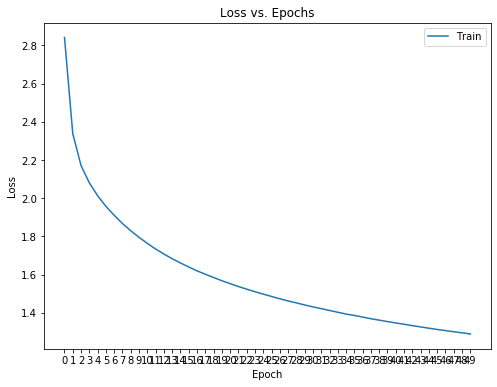

In [24]:
train_model(model5, X, y, n_epochs=50)

In [26]:
model5.save('model5.h5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 75)                37200     
_________________________________________________________________
dense_3 (Dense)              (None, 48)                3648      
Total params: 40,848
Trainable params: 40,848
Non-trainable params: 0
_________________________________________________________________
None


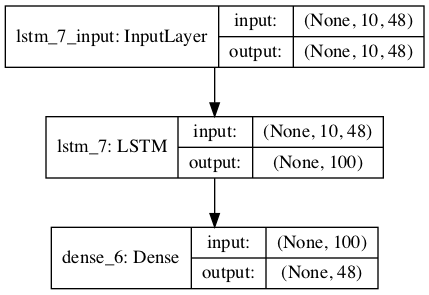

In [39]:
# LSTM: 
model6 = Sequential()
model6.add(LSTM(100, input_shape=(X.shape[1], X.shape[2])))
model6.add(Dense(vocab_size, activation='softmax'))
print(model5.summary())
plot_model(model6, 'model6.png', show_shapes=True)

ally well,
Epoch 1/5
166732/166732 [==============================] - 147s 882us/step - loss: 2.1833
ally well, want to t

Epoch 2/5
166732/166732 [==============================] - 154s 921us/step - loss: 1.7655
ally well, i want yo

Epoch 3/5
166732/166732 [==============================] - 155s 927us/step - loss: 1.5896
ally well, you know 

Epoch 4/5
166732/166732 [==============================] - 155s 927us/step - loss: 1.4763
ally well, i don't l

Epoch 5/5
166732/166732 [==============================] - 155s 928us/step - loss: 1.3920
ally well, i never h



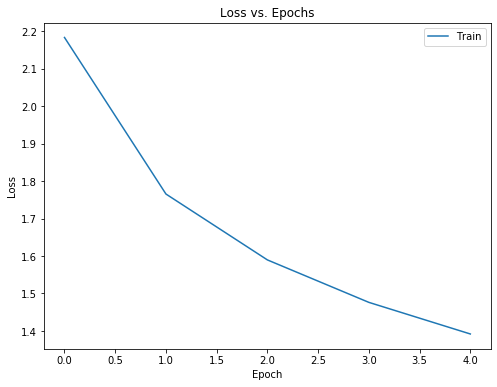

In [44]:
train_model(model6, X, y, n_epochs=5)

In [ ]:
# LSTM: 
model7 = Sequential()
model7.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
model7.add(Dense(vocab_size, activation='softmax'))
print(model5.summary())

In [ ]:
# LSTM: 
model8 = Sequential()
model8.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
model8.add(Dense(vocab_size, activation='softmax'))
print(model5.summary())

In [40]:
model.save('model.h5')

## Other

In [63]:
class MyCustomCallback(keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs=None):
        mapping = load(open('mapping.pkl', 'rb'))
        random_index = np.random.randint(low=0, high=X.shape[0], size=1)
        if epoch%2 == 0:
            prediction = model.predict_classes(np.reshape(X[random_index], (1, X[0].shape[0], X[0].shape[1])))
            out_char = ''
            for char, index in mapping.items():
                if index == prediction:
                    out_char = char
                    break
            print(out_char) # return prediction

def task4(model, X, y, n_epochs=100):
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # fit model
    history = model.fit(X, y, epochs=n_epochs, verbose=1, callbacks=[MyCustomCallback()])
    
    # Plot training loss values vs epochs
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.title('Loss vs. Epochs')
    plt.xticks(np.arange(0, n_epochs, step=1))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper right')
    plt.savefig('epoch_loss.png')
    plt.show()

In [57]:
def get_train_data_old(textfile, window_size, stride):
    # open the file as read, read text, and close file
    file = open(textfile, 'r')
    text = file.read()
    file.close()
    
    # strip of the new line characters so that we 
    # have one long sequence of characters separated only 
    # by white space
    tokens = text.split()
    data = ' '.join(tokens)
    print(len(data))
    
    # get sequences of characters of length window_size+1
    sequences = []
    for i in range(0, len(data) - (window_size + 1), stride):
        sequence = data[i : i + window_size + 1]
        sequences.append(sequence)
    print('Total Sequences: %d' % len(sequences))
    
    # save sequences 
    data = '\n'.join(sequences)
    file = open('train_data.txt', 'w')
    file.write(data)
    file.close()

In [37]:
class predict_during_training(keras.callbacks.Callback):    
    def __init__(self, model, random_seq):
        self.model = model
        self.random_seq = random_seq
    
    def on_epoch_end(self, epoch, model, logs=None):
        # open the file as read, read text, and close file
        file = open('train_data.txt', 'r')
        text = file.read()
        file.close()
        # get list of sequences by splitting the text by new line
        lines = text.split('\n')
        
        # load the mapping
        mapping = load(open('mapping.pkl', 'rb'))
        
        random_index = np.random.randint(low=0, high=len(lines), size=1)[0]
        random_seq = lines[random_index][:-1]
        window_size = len(random_seq)
        if epoch%10 == 0:
            text = predict_characters(self.model, mapping, window_size=window_size, init_chars=random_seq, n_chars=10)
            print(text) # return prediction
        print()

def train_model(model, X, y, n_epochs):
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # fit model
    history = model.fit(X, y, batch_size=500, epochs=n_epochs, verbose=1, callbacks=[predict_during_training(model)])

    # Plot training loss values vs epochs
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'])
    plt.title('Loss vs. Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper right')
    plt.savefig('epoch_loss.png')
    plt.show()

In [127]:
class predict_during_training(keras.callbacks.Callback):    
    def __init__(self, model, sequences):
        self.model = model
        self.sequences = sequences
        
    def on_epoch_end(self, epoch, logs=None):
        mapping = load(open('mapping.pkl', 'rb'))
        window_size = len(self.sequences[0])
        if epoch%1 == 0:
            for i in self.sequences:
                text = predict_characters(self.model, mapping, window_size=window_size, 
                                      init_chars=i, n_chars=10)
                print(text) # return prediction
            print()

def train_model(model, X, y, n_epochs, model_name):
    # open the file as read, read text, and close file
    file = open('train_data.txt', 'r')
    text = file.read()
    file.close()
    # get list of sequences by splitting the text by new line
    lines = text.split('\n')
        
    random_indexes = list(np.random.randint(low=0, high=len(lines), size=4))
    random_sequences = [lines[index][:-1] for index in random_indexes]
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # fit model
    history = model.fit(X, y, epochs=n_epochs, verbose=1, 
                        callbacks=[predict_during_training(model, random_sequences)])
    # save model for later use
    model.save('models/%s.h5' %(model_name))
    # save model history
    with open('train_history/%s.pkl' %(model_name), 'wb') as file:
        dump(history.history, file)
        
    # Plot training loss values vs epochs
    epoch_loss_plot(history.history, model_name)
    
    return history

In [ ]:
class predict_during_training(keras.callbacks.Callback):    
    def __init__(self, model, random_sequences):
        self.model = model
        self.random_sequences = random_sequences
        
    def on_epoch_end(self, epoch, logs=None):
        mapping = load(open('mapping.pkl', 'rb'))
        window_size = len(self.random_seq)
        if epoch%1 == 0:
            for i in self.random_sequences:
                text = predict_characters(self.model, mapping, window_size=window_size, 
                                      init_chars=i, n_chars=10)
                print(text) # return prediction
            print()

def train_model(model, X, y, n_epochs, model_name):
    # open the file as read, read text, and close file
    file = open('train_data.txt', 'r')
    text = file.read()
    file.close()
    # get list of sequences by splitting the text by new line
    lines = text.split('\n')
        
    random_index = np.random.randint(low=0, high=len(lines), size=4)[0]
    random_seq = lines[random_index][:-1]
    print(random_seq)
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # fit model
    history = model.fit(X, y, epochs=n_epochs, verbose=1, 
                        callbacks=[predict_during_training(model, random_seq)])
    # save model for later use
    model.save('models/%s.h5' %(model_name))
    # save model history
    with open('train_history/%s.pkl' %(model_name), 'wb') as file:
        dump(history.history, file)
        
    # Plot training loss values vs epochs
    epoch_loss_plot(history.history, model_name)
    
    return history